# Probe Data - Map Matching
## Nick Paras | Kapil Garg

### Assignment 2

Input: Probe data and map [probe_data_map_matching.rar](https://canvas.northwestern.edu/courses/51440/files/3334329/download?wrap=1)

-The raw probe points in Germany collected in 9 months

-The link data for the links that probe points can be map-matched to.

Tasks:
-- map match probe points to road links

-- derive road slope for each road link

-- evaluate the derived road slope with the surveyed road slope in the link data file

**Please submit your code and slides presentation of your approach and results including evaluation comparing with the slopes in the link data file**

### Setup

We use **Python 3.6** and rely on the dependencies:
* numpy
* scikit-learn
* matplotlib
* pandas

We also use Jupyter Notebooks for our code and reports. For quick setup, please create a conda environment with the following:

    $ conda create --name probe-data pandas matplotlib numpy scikit-learn

and then activate the conda environment with

    $ source activate probe-data


In [12]:
# Imports
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime

%matplotlib inline

# Constants
DATA_DIR = "probe_data_map_matching"

## Loading Probe Data for Map Matching

Here we'll load our data from the two csv's into Pandas DataFrames.

In [13]:
probe_headers = ["sampleID", 
                 "dateTime", 
                 "sourceCode", 
                 "latitude", 
                 "longitude", 
                 "altitude", 
                 "speed", 
                 "heading"]

probe_data = pd.read_csv(os.path.join(DATA_DIR, "Partition6467ProbePoints.csv"), header=None, names=probe_headers)

In [61]:
probe_data['dateTime'] = pd.to_datetime(probe_data['dateTime'])

In [14]:
probe_data.head()

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading
0,3496,6/12/2009 6:12:49 AM,13,51.496868,9.386022,200,23,339
1,3496,6/12/2009 6:12:54 AM,13,51.496682,9.386157,200,10,129
2,3496,6/12/2009 6:12:59 AM,13,51.496705,9.386422,201,21,60
3,3496,6/12/2009 6:13:04 AM,13,51.496749,9.386840,201,0,360
4,3496,6/12/2009 6:13:09 AM,13,51.496864,9.387294,199,0,360


In [15]:
link_headers = ["linkPVID", 
                "refNodeID", 
                "nrefNodeID", 
                "length", 
                "functionalClass", 
                "directionOfTravel", 
                "speedCategory", 
                "fromRefSpeedLimit", 
                "toRefSpeedLimit", 
                "fromRefNumLanes", 
                "toRefNumLanes", 
                "multiDigitized", 
                "urban", 
                "timeZone", 
                "shapeInfo", 
                "curvatureInfo", 
                "slopeInfo"]

link_data = pd.read_csv(os.path.join(DATA_DIR, "Partition6467LinkData.csv"), header=None, names=link_headers)

In [16]:
link_data.head()

,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,curvatureInfo,slopeInfo
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,0.0,51.4965800/9.3862299/|51.4994700/9.3848799/,NaN,NaN
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,0.0,51.4965800/9.3862299/|51.4966899/9.3867100/|51...,NaN,NaN
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4965800/9.3862299/,NaN,NaN
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4990000/9.3836099/,NaN,NaN
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.0,53.0643099/8.7903400/45.79|53.0650299/8.791470...,NaN,0.00/-0.090|110.17/0.062


#### Initial Observations

As can be seen in the first 4 rows of `link_data`, there are missing values in the data. More specifically, we can see right away that `curvatureInfo` and `slopeInfo` are missing from some rows. After checking the `README`, we confirm that this is expected.

### Exploratory Data Analysis

#### Number of Points per Trajectory, Sample Rate, etc.

We know from the literature that the sample rate and/or number of points per trajectory can have a big impact on the quality of our matching, and should therefore inform our choice of algorithm.

In [65]:
sample_sizes = probe_data.groupby(['sampleID'])['dateTime'].size()

In [66]:
len(sample_sizes)

75840

So, there are 75840 unique trajectories.

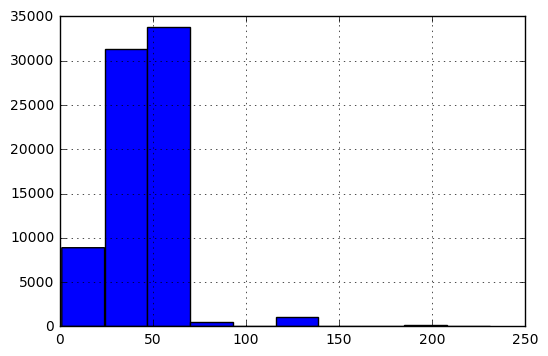

In [67]:
sample_sizes.hist()

And, it appears that most of them have fewer than 100 sample points, although there are some that have quite a bit more.

Now we want to find the sampling rate of the points.

In [68]:
sampling_rates = probe_data.groupby(['sampleID'])

In [69]:
date_bounds = sampling_rates['dateTime'].agg({'date_min': min,
                                              'date_max': max})

num_samples = sampling_rates['dateTime'].size()

In [70]:
date_bounds.head()

,date_max,date_min
sampleID,,
3496,2009-06-12 06:18:11,2009-06-12 06:12:49
4552,2009-06-13 11:52:26,2009-06-13 11:47:18
4553,2009-06-13 11:46:13,2009-06-13 11:41:05
4554,2009-06-13 11:40:00,2009-06-13 11:34:54
4555,2009-06-13 08:37:35,2009-06-13 08:32:26


In [71]:
num_samples.head()

sampleID
3496    189
4552    186
4553    186
4554    186
4555    186
dtype: int64

In [72]:
combined = date_bounds
combined['num_samples'] = num_samples

In [76]:
combined.head()

,date_max,date_min,num_samples
sampleID,,,
3496,2009-06-12 06:18:11,2009-06-12 06:12:49,189
4552,2009-06-13 11:52:26,2009-06-13 11:47:18,186
4553,2009-06-13 11:46:13,2009-06-13 11:41:05,186
4554,2009-06-13 11:40:00,2009-06-13 11:34:54,186
4555,2009-06-13 08:37:35,2009-06-13 08:32:26,186


In [100]:
combined['time_diff'] = combined['date_max'] - combined['date_min']

In [102]:
combined['time_diff'] = combined['time_diff'].apply(lambda x: x.seconds / 60.0)

In [103]:
combined['sample_rate'] = combined['num_samples']/(combined['time_diff'] + 0.00001)

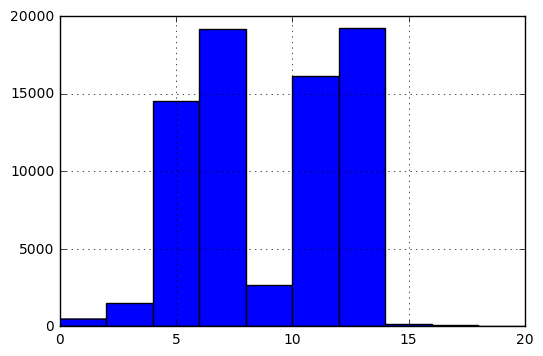

In [106]:
combined['sample_rate'].hist(range=(0,20))

So, we can see that most of the trajectories are sampled between 3 and 15 Hz.

## Simple Point-to-Curve Matching

First, we start with the simplest possible method, _point-to-curve_. We know from the literature that this method (and other simple techniques) is/are highly sensitive to outliers. Therefore, we start with this method more to establish our data pipeline rather than out of expectation of a final solution.

In [17]:
probe_data.head()

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading
0,3496,6/12/2009 6:12:49 AM,13,51.496868,9.386022,200,23,339
1,3496,6/12/2009 6:12:54 AM,13,51.496682,9.386157,200,10,129
2,3496,6/12/2009 6:12:59 AM,13,51.496705,9.386422,201,21,60
3,3496,6/12/2009 6:13:04 AM,13,51.496749,9.386840,201,0,360
4,3496,6/12/2009 6:13:09 AM,13,51.496864,9.387294,199,0,360


In [41]:
probe_data.tail()

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading
3375740,5840319,3/1/2010 5:55:35 AM,13,52.217058,8.974134,130,100,271
3375741,5840319,3/1/2010 5:55:55 AM,13,52.217080,8.966073,130,101,266
3375742,5840319,3/1/2010 5:56:27 AM,13,52.214741,8.953245,136,104,248
3375743,5840319,3/1/2010 5:56:37 AM,13,52.213855,8.949234,138,105,255
3375744,5840319,3/1/2010 5:57:17 AM,13,52.211173,8.932944,138,106,248


In [18]:
trajectories = probe_data.groupby(['sampleID'])

In [19]:
trajectories.get_group(3496).head()

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading
0,3496,6/12/2009 6:12:49 AM,13,51.496868,9.386022,200,23,339
1,3496,6/12/2009 6:12:54 AM,13,51.496682,9.386157,200,10,129
2,3496,6/12/2009 6:12:59 AM,13,51.496705,9.386422,201,21,60
3,3496,6/12/2009 6:13:04 AM,13,51.496749,9.386840,201,0,360
4,3496,6/12/2009 6:13:09 AM,13,51.496864,9.387294,199,0,360


In [20]:
link_data.head()

,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,curvatureInfo,slopeInfo
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,0.0,51.4965800/9.3862299/|51.4994700/9.3848799/,NaN,NaN
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,0.0,51.4965800/9.3862299/|51.4966899/9.3867100/|51...,NaN,NaN
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4965800/9.3862299/,NaN,NaN
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4990000/9.3836099/,NaN,NaN
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.0,53.0643099/8.7903400/45.79|53.0650299/8.791470...,NaN,0.00/-0.090|110.17/0.062


In [21]:
link_data.loc[345]

linkPVID                                                      64988915
refNodeID                                                    189367124
nrefNodeID                                                   189389519
length                                                           86.45
functionalClass                                                      3
directionOfTravel                                                    B
speedCategory                                                        7
fromRefSpeedLimit                                                   30
toRefSpeedLimit                                                     30
fromRefNumLanes                                                      1
toRefNumLanes                                                        1
multiDigitized                                                       F
urban                                                                T
timeZone                                                             0
shapeI

In [22]:
from haversine import haversine

In [23]:
haversine((51.4256599, 10.0942899), (51.4257300, 10.0941699))

0.011400904322461405

In [32]:
# split the lat/lons out from the string
[[float(x) for x in i.split('/')[:2]] for i in link_data.loc[345]['shapeInfo'].split('|')]

[[51.4256599, 10.0942899],
 [51.42573, 10.0941699],
 [51.4257899, 10.09398],
 [51.4258899, 10.0936699],
 [51.42604, 10.0932099]]

In [34]:
link_data[['linkPVID', 'shapeInfo']].head()

,linkPVID,shapeInfo
0,62007637,51.4965800/9.3862299/|51.4994700/9.3848799/
1,567329767,51.4965800/9.3862299/|51.4966899/9.3867100/|51...
2,62007648,51.4962899/9.3849100/|51.4965800/9.3862299/
3,78670326,51.4962899/9.3849100/|51.4990000/9.3836099/
4,51881672,53.0643099/8.7903400/45.79|53.0650299/8.791470...


In [49]:
def find_closest(probe_point):
    tmp_col = link_data[['linkPVID', 'shapeInfo']]
    tmp_col['min_link_dist'] = tmp_col['shapeInfo'].apply(lambda x: min(haversine(probe_point, [float(j) for j in i.split('/')[:2]]) for i in x.split('|')))
    return tmp_col.ix[tmp_col['min_link_dist'].idxmin()]['linkPVID']

In [40]:
find_closest([51.496868, 9.386022])

/Users/Nick/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


linkPVID                                            62007637
shapeInfo        51.4965800/9.3862299/|51.4994700/9.3848799/
min_link_dist                                      0.0351095
Name: 0, dtype: object

In [42]:
find_closest([52.217058, 8.974134])

/Users/Nick/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


linkPVID                                                 772026854
shapeInfo        52.2169200/8.9831799/|52.2169699/8.9808900/|52...
min_link_dist                                           0.00930774
Name: 3748, dtype: object

In [51]:
probe_data[['sampleID', 'latitude', 'longitude']].head().apply(lambda x: find_closest((x[1], x[2])), axis=1)

/Users/Nick/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0     62007637
1     62007637
2     62007637
3    567329767
4    567329767
dtype: int64

In [52]:
probe_data['pointToCurveNearest'] = probe_data[['sampleID', 'latitude', 'longitude']].apply(lambda x: find_closest((x[1], x[2])), axis=1)

/Users/Nick/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


KeyboardInterrupt: 